In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



Source: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html #Creating-the-Network

The below code snippet will read the dataset.

In [2]:
help(glob.glob)

Help on function glob in module glob:

glob(pathname, *, recursive=False)
    Return a list of paths matching a pathname pattern.
    
    The pattern may contain simple shell-style wildcards a la
    fnmatch. However, unlike fnmatch, filenames starting with a
    dot are special cases that are not matched by '*' and '?'
    patterns.
    
    If recursive is true, the pattern '**' will match any files and
    zero or more directories and subdirectories.



In [3]:
all_let = string.ascii_letters + " .,;'-"
all_let

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

In [4]:
all_let = string.ascii_letters + " .,;'-"
n_let = len(all_let) + 1

def getFiles(path):
  return glob.glob(path)

# Unicode string to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_let
    )

In [19]:
all_let[58]
n_let - 1

IndexError: string index out of range

In [5]:
# Read a file and split into lines
def getLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the cat_lin dictionary, a list of lines per category
cat_lin = {}
all_ctg = []
for filename in getFiles(r'.\data\names\*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_ctg.append(category)
    lines = getLines(filename)
    #print (category,len(lines))
    cat_lin[category] = lines

n_ctg = len(all_ctg)


In [6]:
print (len(cat_lin))
all_ctg

18


['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In the next step, we will define the module class to generate the names. The module will be a recurrent neural network.

In [7]:
class NameGeneratorModule(nn.Module):
    def __init__(self, inp_size, hid_size, op_size):
        super(NameGeneratorModule, self).__init__()
        self.hid_size = hid_size

        self.i2h = nn.Linear(n_ctg + inp_size + hid_size, hid_size)
        self.i2o = nn.Linear(n_ctg + inp_size + hid_size, op_size)
        self.o2o = nn.Linear(hid_size + op_size, op_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, inputs, hidden):
        inp_comb = torch.cat((category, inputs, hidden), 1)
        hidden = self.i2h(inp_comb)
        output = self.i2o(inp_comb)
        op_comb = torch.cat((hidden, output), 1)
        output = self.o2o(op_comb)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hid_size)

In [5]:
help(torch.cat)

Help on built-in function cat:

cat(...)
    cat(tensors, dim=0, *, out=None) -> Tensor
    
    Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    All tensors must either have the same shape (except in the concatenating
    dimension) or be empty.
    
    :func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
    and :func:`torch.chunk`.
    
    :func:`torch.cat` can be best understood via examples.
    
    Args:
        tensors (sequence of Tensors): any python sequence of tensors of the same type.
            Non-empty tensors provided must have the same shape, except in the
            cat dimension.
        dim (int, optional): the dimension over which the tensors are concatenated
    
    Keyword args:
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> x = torch.randn(2, 3)
        >>> x
        tensor([[ 0.6580, -1.0969, -0.4614],
                [-0.1034, -0.5790,  0.1497]])
        >>

The below functions will be used to pick the random item from a list and a random line from a category

In [8]:
def randChoice(l):
    #print (l)
    choice =l[random.randint(0, len(l) - 1)] 
    #print (choice)
    return choice

def randTrainPair():
    category = randChoice(all_ctg)
    line = randChoice(cat_lin[category])
    return category, line

The below functions will convert the data to the compatible format for the RNN module.

In [10]:
tensor = torch.zeros(7, 1, 5)
tensor

tensor([[[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]]])

In [21]:
torch.LongTensor([0,0,1,0])

tensor([0, 0, 1, 0])

In [9]:
def categ_Tensor(categ):
    li = all_ctg.index(categ)
    tensor = torch.zeros(1, n_ctg)
    tensor[0][li] = 1
    return tensor

def inp_Tensor(line):
    tensor = torch.zeros(len(line), 1, n_let)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_let.find(letter)] = 1
    return tensor

def tgt_Tensor(line):
    letter_indexes = [all_let.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_let - 1) # EOS
    return torch.LongTensor(letter_indexes)

The below function will create random training examples including category, input and target tensors.

In [28]:
def rand_train_exp():
    category, line = randTrainPair()
    category_tensor = categ_Tensor(category)
    input_line_tensor = inp_Tensor(line)
    target_line_tensor = tgt_Tensor(line)
    #print ('category_tensor:',category_tensor,'i/p_line_tensor:', input_line_tensor, 'target_line_tensor:',target_line_tensor)
    return category_tensor, input_line_tensor, target_line_tensor

In [13]:
rand_train_exp()

category_tensor: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) i/p_line_tensor: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 

(tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

The below function will define the loss criteria for the RNN module.

In [22]:
#Loss
criterion = nn.NLLLoss()
#Learning rate
lr_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    print ('input_line_tensor.size(0):',input_line_tensor.size(0),'i/p line tensor:',input_line_tensor) ### DEBUG
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [30]:
help(rnn.initHidden)

Help on method initHidden in module __main__:

initHidden() method of __main__.NameGeneratorModule instance



In [20]:
target_line_tensor = torch.zeros(4, 1, 3)
print (target_line_tensor)
#target_line_tensor.unsqueeze_(-1)
#target_line_tensor

tensor([[[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]]])


To show time during training, the bellow function is defined.

In [23]:
def time_taken(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In the next step, we will define our RNN model.

In [24]:
rnn = NameGeneratorModule(n_let, 128, n_let)

# We will see the parameters of the defined RNN model.

print(rnn)

NameGeneratorModule(
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In the next step, the model will be trained in 10,000 epochs.

In [29]:
epochs = 100000# 100000
print_every = 5000 #5000
plot_every = 500 # 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iters in range(1, epochs + 1):
    output, loss = train(*rand_train_exp())
    total_loss += loss

    if iters % print_every == 0:
        print('Time: %s, Epoch: (%d - Total Iterations: %d%%),  Loss: %.4f' % (time_taken(start), iters, iters / epochs * 100, loss))

    if iters % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Time: 1m 26s, Epoch: (5000 - Total Iterations: 5%),  Loss: 2.7733
Time: 2m 53s, Epoch: (10000 - Total Iterations: 10%),  Loss: 2.6218
Time: 4m 18s, Epoch: (15000 - Total Iterations: 15%),  Loss: 2.9371
Time: 5m 46s, Epoch: (20000 - Total Iterations: 20%),  Loss: 2.5348
Time: 7m 11s, Epoch: (25000 - Total Iterations: 25%),  Loss: 2.0892
Time: 8m 36s, Epoch: (30000 - Total Iterations: 30%),  Loss: 3.2984
Time: 10m 3s, Epoch: (35000 - Total Iterations: 35%),  Loss: 3.3151
Time: 11m 29s, Epoch: (40000 - Total Iterations: 40%),  Loss: 2.3132
Time: 12m 56s, Epoch: (45000 - Total Iterations: 45%),  Loss: 3.6771
Time: 14m 22s, Epoch: (50000 - Total Iterations: 50%),  Loss: 3.5743
Time: 15m 48s, Epoch: (55000 - Total Iterations: 55%),  Loss: 2.4251
Time: 17m 13s, Epoch: (60000 - Total Iterations: 60%),  Loss: 2.4131
Time: 18m 39s, Epoch: (65000 - Total Iterations: 65%),  Loss: 2.1954
Time: 20m 5s, Epoch: (70000 - Total Iterations: 70%),  Loss: 2.2164
Time: 21m 32s, Epoch: (75000 - Total Iterati

In [42]:
random.randint(0,4)

3

We will visualize the training loss.

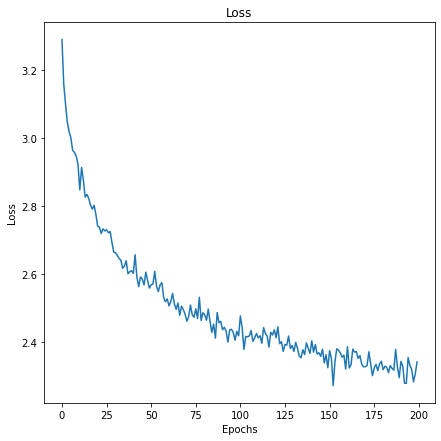

In [31]:
plt.figure(figsize=(7,7))
plt.title("Loss")
plt.plot(all_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Finally, we will sample our model to test it on generating the names belonging to languages when given a starting alphabet letter.

In [46]:
max_length = 20
# Sample from a category and starting letter
def sample_model(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categ_Tensor(category)
        inputs = inp_Tensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, inputs[0], hidden)
            #print ('output: ',output)### debug
            #print (help(output.topk))### debug
            #print ('output.topk:',output.topk)### debug
            topv, topi = output.topk(1)
            #print ('(output.topk(1)) topv, topi:',topv, topi) ### debug
            topi = topi[0][0]
            if topi == n_let - 1:
                break
            else:
                letter = all_let[topi]
                output_name += letter
            inputs = inp_Tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def sample_names(category, start_letters='XYZ'):
    for start_letter in start_letters:
        print(sample_model(category, start_letter))

In [47]:
print("English names:-")
sample_names('English', 'BPRT')

English names:-
Balles
Parter
Roski
Tollen


Now, we will check the sampled model to generate names when given a language and the starting alphabet letter.

In [37]:


print("Italian:-")
sample_names('Italian', 'BPRT')
print("\nKorean:-")
sample_names('Korean', 'CMRS')
print("\nRussian:-")
sample_names('Russian', 'AJLN')
print("\nVietnamese:-")
sample_names('Vietnamese', 'LMT')


print ('\n more Russian names:-')
sample_names('Russian', 'RUS')

print ('\n German names:-')
sample_names('German', 'GER')

print ('\n Spanish names:-')
sample_names('Spanish', 'SPA')

print ('\n Chinese names:-')
sample_names('Chinese', 'CHI')


Italian:-
Barin
Parichi
Romani
Tarichi

Korean:-
Cho
Man
Ro
Sho

Russian:-
Alakan
Jonghar
Lakarak
Nakarov

Vietnamese:-
La
Ma
Than

 more Russian names:-
Rovanov
Uakin
Sharakin

 German names:-
Garer
Eerre
Romer

 Spanish names:-
Sallan
Paran
Arane

 Chinese names:-
Cha
Ha
Iun


So, as we can see above, our model has generated names belonging to the language categories and starting with the input alphabet.

In [1]:
!pip install opencv-python

  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Running setup.py bdist_wheel for opencv-python: started
  Running setup.py bdist_wheel for opencv-python: finished with status 'error'
  Complete output from command c:\python37\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\admin\\AppData\\Local\\Temp\\pip-install-nzvmnyf7\\opencv-python\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\admin\AppData\Local\Temp\pip-wheel-p2d952b4 --python-tag cp37:
  
  
  --------------------------------------------------------------------------------
  -- Trying "Ninja (Visual Studio 17 2022 x64 v143)" generator
  --------------------------------
  ---------------------------
  ----------------------
  ---------------

  Failed building wheel for opencv-python
Command "c:\python37\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\admin\\AppData\\Local\\Temp\\pip-install-nzvmnyf7\\opencv-python\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\admin\AppData\Local\Temp\pip-record-md0sfdd9\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\admin\AppData\Local\Temp\pip-install-nzvmnyf7\opencv-python\
You are using pip version 18.1, however version 22.0.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  
    could not find any instance of Visual Studio.
  
  
  
  -- Configuring incomplete, errors occurred!
  See also "C:/Users/admin/AppData/Local/Temp/pip-install-nzvmnyf7/opencv-python/_cmake_test_compile/build/CMakeFiles/CMakeOutput.log".
  --
  -------
  ------------
  -----------------
  ----------------------
  ---------------------------
  --------------------------------
  -- Trying "Visual Studio 17 2022 x64 v143" generator - failure
  --------------------------------------------------------------------------------
  
  
  
  --------------------------------------------------------------------------------
  -- Trying "Ninja (Visual Studio 16 2019 x64 v142)" generator
  --------------------------------
  ---------------------------
  ----------------------
  -----------------
  ------------
  -------
  --
  Not searching for unused variables given on the command line.
  CMake Error at CMakeLists.txt:2 (PROJECT):
    Generator
  
      Ninja
  
    does not support platform sp

    ----------------------
    -----------------
    ------------
    -------
    --
    Not searching for unused variables given on the command line.
    CMake Error at CMakeLists.txt:2 (PROJECT):
      Generator
    
        Ninja
    
      does not support platform specification, but platform
    
        x64
    
      was specified.
    
    
    -- Configuring incomplete, errors occurred!
    See also "C:/Users/admin/AppData/Local/Temp/pip-install-nzvmnyf7/opencv-python/_cmake_test_compile/build/CMakeFiles/CMakeOutput.log".
    --
    -------
    ------------
    -----------------
    ----------------------
    ---------------------------
    --------------------------------
    -- Trying "Ninja (Visual Studio 17 2022 x64 v143)" generator - failure
    --------------------------------------------------------------------------------
    
    
    
    --------------------------------------------------------------------------------
    -- Trying "Visual Studio 17 2022 x64 v143" ge